In [1]:
import numpy as np
from numpy import matmul as mul
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def LoadData(path):
    X = []
    Y = []
    with open(path,'r')as file:
        for data in file.readlines():
            xy = data.split()
            X.append(float(xy[0]))
            Y.append(float(xy[1]))
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)
    return X,Y

$$Rational Quadratic Kernel: k(x_i, x_j) = \sigma^2(1+\frac{(x_i - x_j)^2}{2\alpha l^2})^{-\alpha}$$

In [3]:
def RQK(xi,xj,sigma, l,a):
    return (sigma**2)*(1+(xi-xj)**2/(2*a*l**2))**(-a)

$$Covariance Matrix: C(x_n,x_m) = k(x_n,x_m)+\beta^{-1}\delta_{n,m}$$

In [4]:
def Cov(X,beta, sigma, length, alpha):
    N = len(X)
    C = np.zeros((N,N))
    for n in range(N):
        for m in range(N):
            C[n][m] = RQK(X[n],X[m], sigma, length, alpha)
            if n==m:
                C[n][m]+=1/beta
    return C

$$\mu(x^*) = k(x,x^*)^TC^{-1}y $$<br>
$$\sigma(x^*) = k(x^*,x^*) + \beta^{-1} - k(x,x^*)^TC^{-1}k(x,x^*) $$

In [5]:
def Predict(X_train,Y_train,X_test, train_num, test_num,beta, sigma, length, alpha,C):
    mean = np.zeros(test_num)
    var = np.zeros(test_num)
    
    for m in range (test_num):
        # Calculate k(x,x*)
        Km = np.zeros((train_num,1))
        for n in range(train_num):
            Km[n][0] = RQK(X_train[n],X_test[m], sigma, length, alpha)
        
        # calculate mean and var
        # mean = k(x,x*)T C-1 y
        mean[m] = mul(mul(Km.T, inv(C)),Y_train)
        # var = k(x*,x*) + B-1 - k(x,x*)T C-1 k(x,x*)
        K = RQK(X_test[n],X_test[n], sigma, length, alpha)
        var[m] = K + 1/beta -  mul(mul(Km.T, inv(C)),Km)
    return mean, var

In [6]:
def Viz(X,Y,mean,var, test_num, sigma, l, a):
    fig = plt.figure()
    x_range = np.linspace(-60, 60, test_num)
    lower_bound = mean - 1.96 * np.sqrt(var)
    upper_bound = mean + 1.96 * np.sqrt(var)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, color="blue", label="Training Data Points", alpha=0.7)
    plt.plot(x_range, mean, color="red", label="Prediction Mean", linewidth=2)
    plt.fill_between(x_range, lower_bound, upper_bound, color="red", alpha=0.3,
                     label="95% Confidence Interval")
    
    plt.xlim(-60, 60)
    plt.title(f"sigma: {sigma:.4f}, length scale: {l:.4f}, alpha: {a:.4f}", fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [7]:
def GP(X_train,Y_train,X_test, train_num, test_num, beta, sigma, length, alpha):
    C = Cov(X_train,beta, sigma, length, alpha)
    mean,var = Predict(X_train,Y_train,X_test, train_num, test_num,beta, sigma, length, alpha, C)
    Viz(X_train,Y_train, mean, var, test_num, sigma, length, alpha)

$$likelihood = \frac{1}{|2\pi|^{\frac{N}{2}}}\frac{1}{|C_\theta|^{\frac{1}{2}}} e^{-\frac{1}{2} y^T C_\theta^{-1} y }$$<br>
$$loglik = -{\frac{N}{2}}ln(2\pi) -{\frac{1}{2}}ln(C_\theta) - { \frac{1}{2} y^T C_\theta^{-1} y }$$<br>
$$negloglik = {\frac{N}{2}}ln(2\pi) +{\frac{1}{2}}ln(|C_\theta|) +{ \frac{1}{2} y^T C_\theta^{-1} y }$$

In [8]:
def NegLogLik(theta, X, Y, beta, N):
    theta = theta.reshape(len(theta), 1)
    sigma = theta[0]
    length = theta[1]
    alpha = theta[2]
    
    C_theta = Cov(X,beta, sigma, length, alpha)
    
    NLL = N* np.log(2*np.pi)/2
    NLL += np.log(np.linalg.det(C_theta))/2
    NLL += mul(mul(Y.T,inv(C_theta)),Y)/2

    return float(NLL[0])

<Figure size 432x288 with 0 Axes>

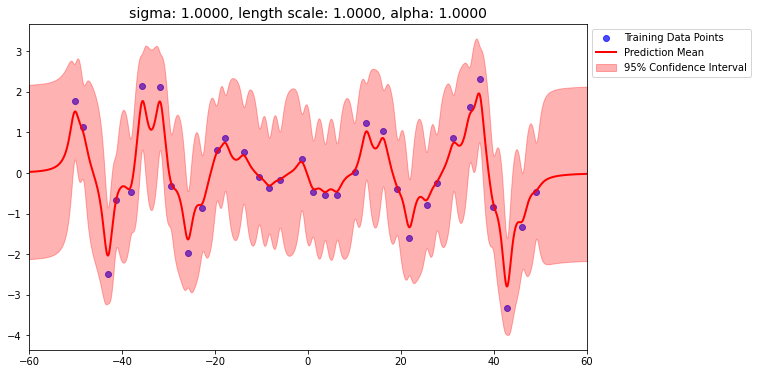

<Figure size 432x288 with 0 Axes>

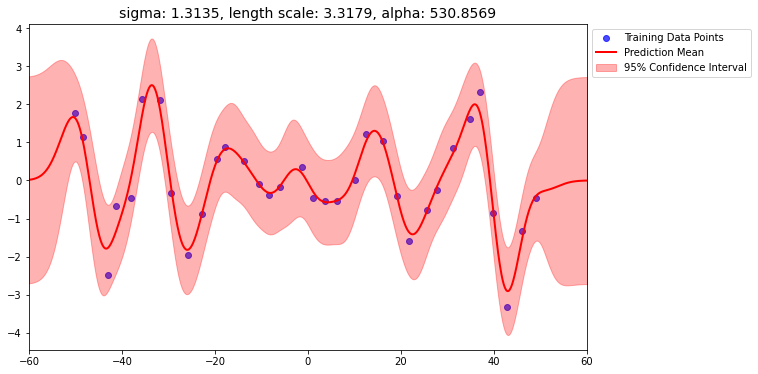

In [9]:
X_train,Y_train = LoadData("./data/input.data")
train_num = len(X_train)
test_num = 1000
X_test = np.linspace(-60, 60, test_num).reshape(-1, 1)
beta = 5

# initial parameters for RQ kernel
sigma = 1   
length = 1  
alpha = 1   

GP(X_train,Y_train,X_test, train_num, test_num, beta, sigma, length, alpha)

Opt = minimize(NegLogLik, [sigma,length,alpha],
              args = (X_train, Y_train, beta, train_num))
sigma = Opt.x[0]
length = Opt.x[1]
alpha = Opt.x[2]
GP(X_train,Y_train,X_test, train_num, test_num, beta, sigma, length, alpha)